In [1]:
import sys
import torch

seed = 42
torch.set_default_dtype(torch.float64)
torch.manual_seed(seed)
torch.set_printoptions(precision=2, sci_mode=False)


import pandas as pd
import numpy as np
import ast
import copy

# Load Modules
sys.path.append("..")
from os.path import expanduser
home = expanduser("~")
from fiora.MOL.constants import DEFAULT_PPM, PPM, DEFAULT_MODES
from fiora.IO.LibraryLoader import LibraryLoader
from fiora.MOL.FragmentationTree import FragmentationTree 
from fiora.visualization.define_colors import set_light_theme
from fiora.visualization.define_colors import *
set_light_theme()
import fiora.visualization.spectrum_visualizer as sv


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score
import scipy
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

print(f'Working with Python {sys.version}')


[09:39:26] WARNING: not removing hydrogen atom without neighbors
[09:39:26] WARNING: not removing hydrogen atom without neighbors
[09:39:26] WARNING: not removing hydrogen atom without neighbors


Working with Python 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]


## Data

In [2]:
def read_log(file):
    LOG = pd.read_csv(file, sep="\t")
    eval_columns = LOG.columns[3:]

    for col in eval_columns:
        LOG[col] = LOG[col].apply(lambda x: ast.literal_eval(x.replace('nan', 'None')))
    return LOG

In [3]:
path = f"{home}/data/metabolites/benchmarking/"
suffix = "_cp_Jan24.csv"
NAMES = ["GraphConv", "RGCNConv", "GAT", "TransformerConv"] #  , "CGConv_depth.csv",

log = []
for name in NAMES:
    new_log = read_log(path + name + suffix)
    log.append(new_log)

log = pd.concat(log, ignore_index=True)

In [4]:
log


,depth,gnn_type,model,cp,validation,test,casmi16,casmi22,casmi16+,casmi16-,casmi22+,casmi22-
0,0,GraphConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"{'epoch': 96, 'val_loss': 9.808177128434181e-0...","[0.8070551423969587, 0.6667071008127707, 0.588...","[0.7007809142523294, 0.612024046427903, 0.5837...","[0.7924762496719242, 0.7036873277509316, 0.821...","[0.18919280611886374, 0.12891196439337407, 0.0...","[0.6164090442678308, 0.9655796604112373, 0.837...","[0.7924762432555723, 0.703687327434546, 0.8217...","[0.18919280611886374, 0.12891196439337407, 0.0...","[0.6419822040023024, 0.5037954766649189, 0.228..."
1,1,GraphConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"{'epoch': 81, 'val_loss': 7.633271161466837e-0...","[0.8453675324738402, 0.7615056256407017, 0.711...","[0.8615467169929661, 0.8049664962296178, 0.805...","[0.8497836627290483, 0.725625669435009, 0.8696...","[0.31999756582465994, 0.13493713055847847, 0.0...","[0.6638763185067331, 0.943000792589276, 0.8726...","[0.8497836627290483, 0.7256256647529489, 0.869...","[0.31999756582465994, 0.13493713055847847, 0.0...","[0.8720653770500627, 0.767804061363079, 0.3147..."
2,2,GraphConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"{'epoch': 81, 'val_loss': 7.102817471604794e-0...","[0.8631324391765643, 0.7901128036501043, 0.764...","[0.8807494112211791, 0.8473930307880111, 0.848...","[0.8569009507254279, 0.670872852061631, 0.8570...","[0.33935685343861877, 0.1497386101467144, 0.07...","[0.7584677862888478, 0.9393425375005672, 0.917...","[0.8569009493328394, 0.670872848938579, 0.8570...","[0.33935685343861877, 0.14973860446333503, 0.0...","[0.8747994354172516, 0.765733734068809, 0.3057..."
3,3,GraphConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"{'epoch': 80, 'val_loss': 6.826363824075088e-0...","[0.9240624287812772, 0.9215437079788981, 0.898...","[0.8390626132431285, 0.7960994794812776, 0.794...","[0.8666505681177348, 0.609963690517596, 0.8570...","[0.2974202584317185, 0.10966297125266829, 0.0,...","[0.7753976331400724, 0.9798659811233904, 0.929...","[0.8666505684445428, 0.6099636804591612, 0.857...","[0.29742026159283114, 0.10966297671567288, 0.0...","[0.8881516675592416, 0.7997597364254692, 0.313..."
4,4,GraphConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"{'epoch': 116, 'val_loss': 6.453752575907856e-...","[0.9164172841831615, 0.8206912882892013, 0.803...","[0.8309474174380809, 0.7703323657997456, 0.764...","[0.8710730861702655, 0.6335523981793393, 0.856...","[0.2177309406482908, 0.06801481768807102, 0.0,...","[0.7665128045987488, 0.9929282289280948, 0.929...","[0.8710730839800203, 0.6335523898196087, 0.856...","[0.21773095251291677, 0.0680148079449901, 0.0,...","[0.945585900879694, 0.8893732769672965, 0.4138..."
5,5,GraphConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"{'epoch': 121, 'val_loss': 6.374818622134626e-...","[0.9184240940020658, 0.8343902578016329, 0.823...","[0.838065202919321, 0.7690191169512596, 0.7570...","[0.88897293035711, 0.6752053165183411, 0.88062...","[0.21715945836054504, 0.06966011048872629, 0.0...","[0.7825345477134387, 0.984583728310478, 0.9295...","[0.88897293035711, 0.6752053223189094, 0.88062...","[0.2171594749241168, 0.06966011869066632, 0.0,...","[0.9475563985926653, 0.8796011785302835, 0.400..."
6,6,GraphConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"{'epoch': 105, 'val_loss': 6.533033592859283e-...","[0.9005982558650338, 0.8128447769472258, 0.805...","[0.849034434647343, 0.7973043241670239, 0.7931...","[0.8402076938859284, 0.6171727476988874, 0.868...","[0.2916191381555986, 0.1053268377328988, 0.0, ...","[0.7914749624146012, 0.9926106752436531, 0.929...","[0.8402076838466732, 0.6171727404023234, 0.868...","[0.29161913722626814, 0.10532682916192958, 0.0...","[0.9278776397428238, 0.8634126507758959, 0.393..."
7,7,GraphConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"{'epoch': 85, 'val_loss': 6.626113463426009e-0...","[0.9190577059333948, 0.8560060245069928, 0.828...","[0.8911826293975004, 0

In [5]:
gnn_type_labels={"GraphConv": "GCN", "CGConv": "CGC", "GAT": "GAT", "RGCNConv": "RGCN", "TransformerConv": "Transformer"}

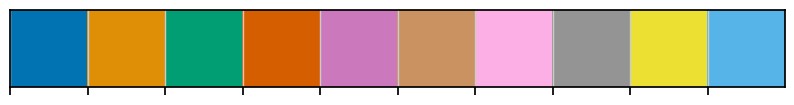

In [6]:
sns.palplot(sns.color_palette("colorblind"))
plt.show()

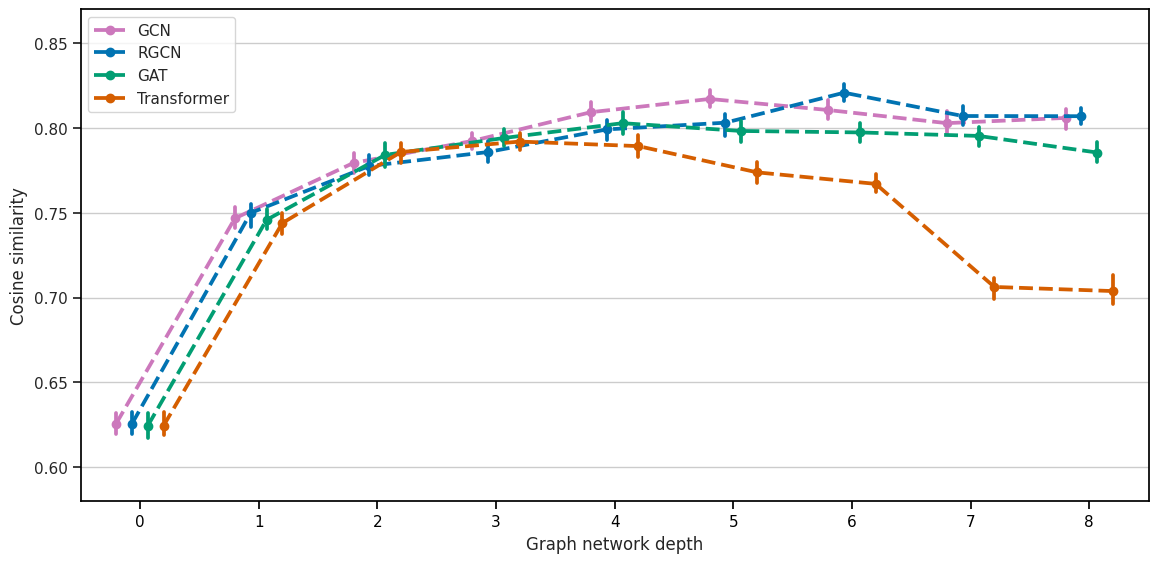

In [61]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
plt.subplots_adjust(top=0.94, bottom=0.12, right=0.97, left=0.08)

color_blind4=[sns.color_palette("colorblind")[4], sns.color_palette("colorblind")[0], sns.color_palette("colorblind")[2], sns.color_palette("colorblind")[3]]
L = log.explode("validation")
L["gnn_type"] = L["gnn_type"].map(gnn_type_labels)
sns.pointplot(data=L, x="depth", y="validation", estimator="median", capsize=.0,  markers="o", palette=color_blind4, markersize=5, errorbar=('ci', 95), linestyles='--', hue="gnn_type", dodge=0.4) # ci=('ci', 0.95),, palette=tri_palette,  bins=[x/10.0 for x in list(range(0,10,1))]), multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")
#plt.ylim([0.4, 0.8]) # markers=["o", "X", "^","*"]
plt.ylabel("Cosine similarity")
plt.xlabel("Graph network depth")
plt.yticks(np.arange(0.5, 0.91, 0.05))
# plt.autoscale(enable=True, axis='y')
plt.ylim(0.58, 0.87)
#plt.ylim(0.25, 0.95)
plt.legend(title="")

# for line in ax.lines:
#     marker = line.get_marker()
#     line.set_markeredgecolor('black') 

# fig.savefig(f"{home}/images/paper/grid_params3.svg", format="svg", dpi=600)
# fig.savefig(f"{home}/images/paper/grid_params3.png", format="png", dpi=600)
# fig.savefig(f"{home}/images/paper/grid_params3.pdf", format="pdf", dpi=600)
plt.show()

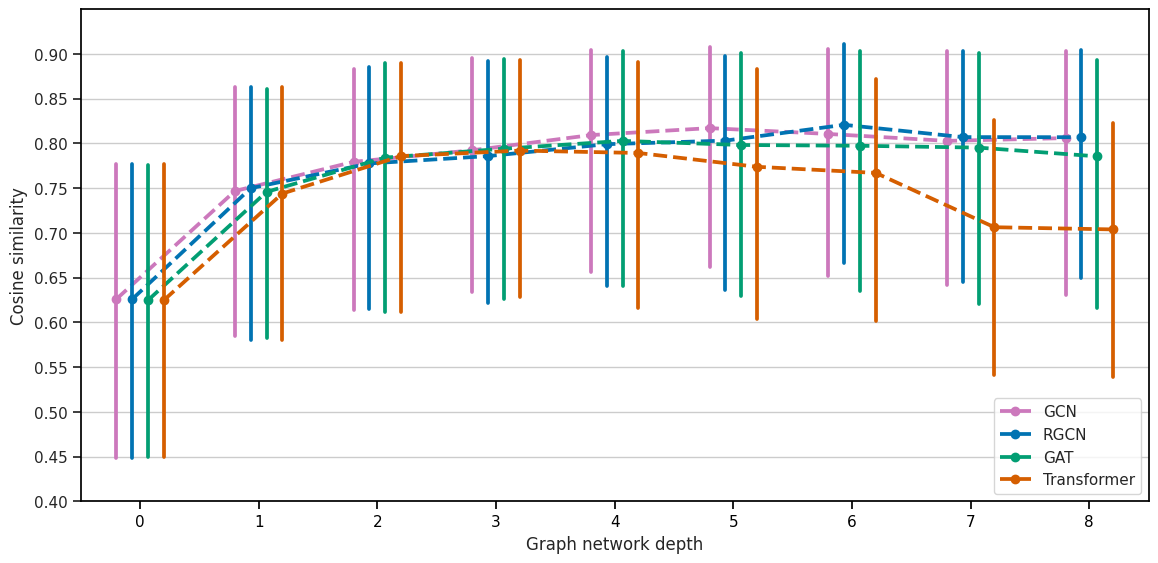

In [64]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
plt.subplots_adjust(top=0.94, bottom=0.12, right=0.97, left=0.08)

color_blind4=[sns.color_palette("colorblind")[4], sns.color_palette("colorblind")[0], sns.color_palette("colorblind")[2], sns.color_palette("colorblind")[3]]
L = log.explode("validation")
L["gnn_type"] = L["gnn_type"].map(gnn_type_labels)
sns.pointplot(data=L, x="depth", y="validation", estimator="median", capsize=.0,  markers="o", palette=color_blind4, markersize=5, errorbar=('pi', 50), linestyles='--', hue="gnn_type", dodge=0.4) # ci=('ci', 0.95),, palette=tri_palette,  bins=[x/10.0 for x in list(range(0,10,1))]), multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")
#plt.ylim([0.4, 0.8]) # markers=["o", "X", "^","*"]
plt.ylabel("Cosine similarity")
plt.xlabel("Graph network depth")
plt.yticks(np.arange(0.4, 0.91, 0.05))
# plt.autoscale(enable=True, axis='y')
plt.ylim(0.4, 0.95)
#plt.ylim(0.25, 0.95)
plt.legend(title="")

# for line in ax.lines:
#     marker = line.get_marker()
#     line.set_markeredgecolor('black') 

# fig.savefig(f"{home}/images/paper/grid_params3.svg", format="svg", dpi=600)
# fig.savefig(f"{home}/images/paper/grid_params3.png", format="png", dpi=600)
# fig.savefig(f"{home}/images/paper/grid_params3.pdf", format="pdf", dpi=600)
plt.show()

In [8]:
import numpy as np 
import scipy.stats as st 
from scipy.stats import bootstrap

def print_stats(scores):
    print(f"Num of spectra: {len(scores)}")
    print(f"Median:\t{np.median(scores):.3f}")
    print(f"Var:\t{np.var(scores):.3f} (Standard deviation: {np.std(scores):.3f})")
    conf_in_t = st.t.interval(confidence=0.95, df=len(scores)-1, loc=np.median(scores), scale=st.sem(scores)) 
    conf_in_boot = bootstrap((scores,), np.median, confidence_level=0.95)
    print(f"95%CI: {conf_in_t} (from t distribution)")
    print(f"95%CI: {conf_in_boot.confidence_interval} (from bootstrapping)")

In [9]:
val_scores = L[(L["gnn_type"] == "RGCN") & (L["depth"] == 6)]["validation"]
print_stats(list(val_scores))

Num of spectra: 7212
Median:	0.821
Var:	0.042 (Standard deviation: 0.206)
95%CI: (0.8160764988782188, 0.8255678083244333) (from t distribution)
95%CI: ConfidenceInterval(low=0.8159496565217805, high=0.8257998580760703) (from bootstrapping)


In [10]:
eval_columns = log.columns[4:]
log[log["gnn_type"] == "RGCNConv"][eval_columns].apply(lambda x: x.apply(np.mean) ,axis=1)

,validation,test,casmi16,casmi22,casmi16+,casmi16-,casmi22+,casmi22-
9,0.602392,0.612125,0.561964,0.261672,0.534424,0.605143,0.258722,0.266265
10,0.702033,0.713034,0.638223,0.301221,0.614900,0.674792,0.298691,0.305162
11,0.727112,0.741422,0.645053,0.313182,0.629675,0.669162,0.311040,0.316518
12,0.731619,0.749774,0.650715,0.318373,0.639789,0.667846,0.315666,0.322589
13,0.742559,0.761496,0.657252,0.322900,0.640387,0.683694,0.324921,0.319753
14,0.742377,0.758383,0.656789,0.319868,0.640811,0.681841,0.320568,0.318777
15,0.758752,0.773613,0.657871,0.322317,0.636921,0.690720,0.327846,0.313707
16,0.747053,0.766425,0.659102,0.328444,0.636020,0.695293,0.330530,0.325195
17,0.746288,0.765973,0.654660,0.326335,0.634789,0.685816,0.327027,0.325258


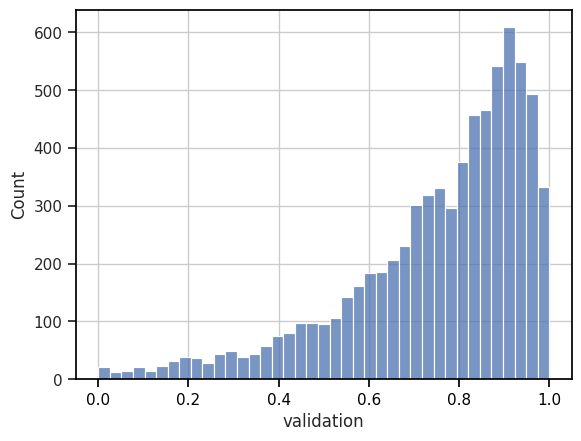

0.8093291723056215
0.2019783284851107


In [42]:
log4 = log[(log["gnn_type"] == "GraphConv") & (log["depth"] == 4)]
L4 = log4.explode("validation")
sns.histplot(data=L4, x="validation")
plt.show()

print(L4["validation"].median())
print(np.std(L4["validation"]))

<Axes: ylabel='validation'>

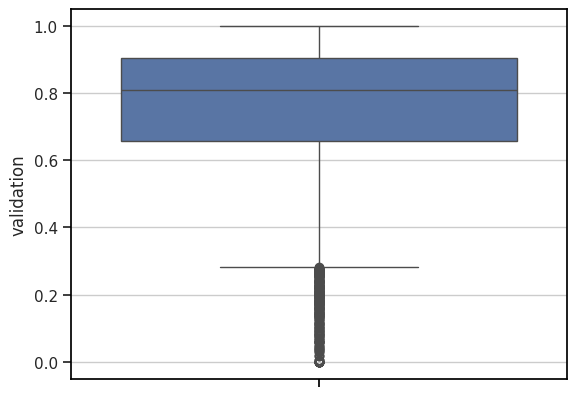

In [44]:
sns.boxplot(data=L4, y="validation")


In [26]:
log

,depth,gnn_type,model,cp,validation,test,casmi16,casmi22,casmi16+,casmi16-,casmi22+,casmi22-
0,0,GraphConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"{'epoch': 96, 'val_loss': 9.808177128434181e-0...","[0.8070551423969587, 0.6667071008127707, 0.588...","[0.7007809142523294, 0.612024046427903, 0.5837...","[0.7924762496719242, 0.7036873277509316, 0.821...","[0.18919280611886374, 0.12891196439337407, 0.0...","[0.6164090442678308, 0.9655796604112373, 0.837...","[0.7924762432555723, 0.703687327434546, 0.8217...","[0.18919280611886374, 0.12891196439337407, 0.0...","[0.6419822040023024, 0.5037954766649189, 0.228..."
1,1,GraphConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"{'epoch': 81, 'val_loss': 7.633271161466837e-0...","[0.8453675324738402, 0.7615056256407017, 0.711...","[0.8615467169929661, 0.8049664962296178, 0.805...","[0.8497836627290483, 0.725625669435009, 0.8696...","[0.31999756582465994, 0.13493713055847847, 0.0...","[0.6638763185067331, 0.943000792589276, 0.8726...","[0.8497836627290483, 0.7256256647529489, 0.869...","[0.31999756582465994, 0.13493713055847847, 0.0...","[0.8720653770500627, 0.767804061363079, 0.3147..."
2,2,GraphConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"{'epoch': 81, 'val_loss': 7.102817471604794e-0...","[0.8631324391765643, 0.7901128036501043, 0.764...","[0.8807494112211791, 0.8473930307880111, 0.848...","[0.8569009507254279, 0.670872852061631, 0.8570...","[0.33935685343861877, 0.1497386101467144, 0.07...","[0.7584677862888478, 0.9393425375005672, 0.917...","[0.8569009493328394, 0.670872848938579, 0.8570...","[0.33935685343861877, 0.14973860446333503, 0.0...","[0.8747994354172516, 0.765733734068809, 0.3057..."
3,3,GraphConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"{'epoch': 80, 'val_loss': 6.826363824075088e-0...","[0.9240624287812772, 0.9215437079788981, 0.898...","[0.8390626132431285, 0.7960994794812776, 0.794...","[0.8666505681177348, 0.609963690517596, 0.8570...","[0.2974202584317185, 0.10966297125266829, 0.0,...","[0.7753976331400724, 0.9798659811233904, 0.929...","[0.8666505684445428, 0.6099636804591612, 0.857...","[0.29742026159283114, 0.10966297671567288, 0.0...","[0.8881516675592416, 0.7997597364254692, 0.313..."
4,4,GraphConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"{'epoch': 116, 'val_loss': 6.453752575907856e-...","[0.9164172841831615, 0.8206912882892013, 0.803...","[0.8309474174380809, 0.7703323657997456, 0.764...","[0.8710730861702655, 0.6335523981793393, 0.856...","[0.2177309406482908, 0.06801481768807102, 0.0,...","[0.7665128045987488, 0.9929282289280948, 0.929...","[0.8710730839800203, 0.6335523898196087, 0.856...","[0.21773095251291677, 0.0680148079449901, 0.0,...","[0.945585900879694, 0.8893732769672965, 0.4138..."
5,5,GraphConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"{'epoch': 121, 'val_loss': 6.374818622134626e-...","[0.9184240940020658, 0.8343902578016329, 0.823...","[0.838065202919321, 0.7690191169512596, 0.7570...","[0.88897293035711, 0.6752053165183411, 0.88062...","[0.21715945836054504, 0.06966011048872629, 0.0...","[0.7825345477134387, 0.984583728310478, 0.9295...","[0.88897293035711, 0.6752053223189094, 0.88062...","[0.2171594749241168, 0.06966011869066632, 0.0,...","[0.9475563985926653, 0.8796011785302835, 0.400..."
6,6,GraphConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"{'epoch': 105, 'val_loss': 6.533033592859283e-...","[0.9005982558650338, 0.8128447769472258, 0.805...","[0.849034434647343, 0.7973043241670239, 0.7931...","[0.8402076938859284, 0.6171727476988874, 0.868...","[0.2916191381555986, 0.1053268377328988, 0.0, ...","[0.7914749624146012, 0.9926106752436531, 0.929...","[0.8402076838466732, 0.6171727404023234, 0.868...","[0.29161913722626814, 0.10532682916192958, 0.0...","[0.9278776397428238, 0.8634126507758959, 0.393..."
7,7,GraphConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"{'epoch': 85, 'val_loss': 6.626113463426009e-0...","[0.9190577059333948, 0.8560060245069928, 0.828...","[0.8911826293975004, 0